# TO DO

1. Pick a dataset
2. Download The dataset
3. Import the dataset using Pytorch
4. Explore the dataset
5. Prepare the dataset for training
6. Train the Dataset 
7. Predict

## Download The Dataset

Using OpenDataset and Donwload the dataset from https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
#!pip install opendatasets --upgrade --quiet

In [2]:
#import opendatasets as od

In [3]:
#dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [4]:
#od.download(dataset_url)

In [5]:
data_dir = '../input/flowers-recognition/flowers/flowers'

In [6]:
import os
for file in os.listdir(data_dir):
    print(data_dir+file)

../input/flowers-recognition/flowers/flowersdandelion
../input/flowers-recognition/flowers/flowersdaisy
../input/flowers-recognition/flowers/flowerssunflower
../input/flowers-recognition/flowers/flowerstulip
../input/flowers-recognition/flowers/flowersrose


In [7]:
os.listdir(data_dir)

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [8]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1055
daisy : 769
sunflower : 734
tulip : 984
rose : 784


### Imoprt the datasets into Pytorch

Use the `ImageFloder` class from `torchvision`

In [9]:
from torchvision.datasets import ImageFolder

In [10]:
dataset = ImageFolder(data_dir)

In [11]:
len(dataset)

4323

In [12]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F8B6697A390>, 0)

In [13]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

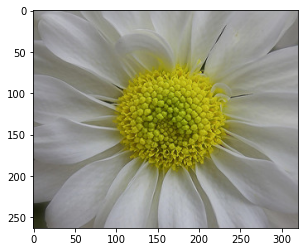

In [15]:
img, label = dataset[0]
plt.imshow(img);

In [16]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

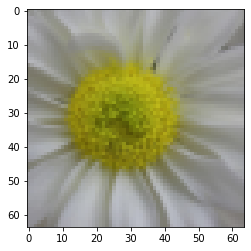

In [17]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0));

In [18]:
val_pct = 0.1 # validation %
val_size = int(val_pct * len(dataset))

train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [19]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3891, 432)

In [20]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
torch.cuda.is_available()

True

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
img, label = dataset[0]

In [24]:
img.device

device(type='cpu')

In [25]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [26]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      '''calculate loss for a batch of training data'''

      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss
    
    def validation_step(self, batch):
      '''calculate loss for a batch of validation data'''
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained =True):
        super().__init__()
        
        #Use a Pretrainned model
        self.network = models.resnet34(pretrained = pretrained)
        #replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, 
                                    num_classes)

    def forward(self, xb):
        return self.network(xb)

In [28]:
model = to_device(ResNet34(len(dataset.classes), pretrained =True), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [29]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [30]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size), 
                                            tt.RandomCrop(img_size), 
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

In [31]:

from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

val_dl = DataLoader(valid_ds, 
                    batch_size*2, 
                    num_workers=4, 
                    pin_memory=True)

In [32]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [33]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [34]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9929959774017334, 'val_acc': 0.177734375}]

In [36]:
history += fit_one_cycle(10, 0.001,model, train_dl, valid_dl, weight_decay=0.01, grad_clip = 0.1, opt_func = torch.optim.Adam)


Epoch [0], train_loss: 0.9699, val_loss: 0.5612, val_acc: 0.7975



Epoch [1], train_loss: 0.5371, val_loss: 1.5677, val_acc: 0.6348



Epoch [2], train_loss: 0.5925, val_loss: 0.9847, val_acc: 0.6595



Epoch [3], train_loss: 0.5793, val_loss: 0.7320, val_acc: 0.7214



Epoch [4], train_loss: 0.5026, val_loss: 0.5917, val_acc: 0.7760



Epoch [5], train_loss: 0.4480, val_loss: 0.6286, val_acc: 0.7891



Epoch [6], train_loss: 0.3716, val_loss: 0.6870, val_acc: 0.7604



Epoch [7], train_loss: 0.2532, val_loss: 0.5453, val_acc: 0.8066



Epoch [8], train_loss: 0.1252, val_loss: 0.4969, val_acc: 0.8379



Epoch [9], train_loss: 0.0721, val_loss: 0.4754, val_acc: 0.8665


In [37]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [38]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

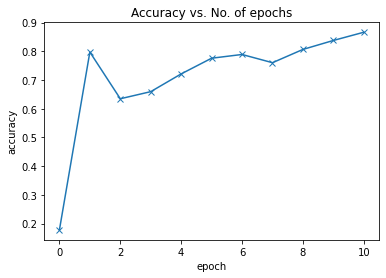

In [39]:
plot_accuracies(history)

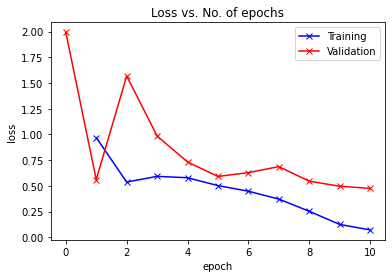

In [40]:
plot_losses(history)

In [41]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('batch no.')
    plt.ylabel('learning rate')
    plt.title('learning rate vs batch no.');

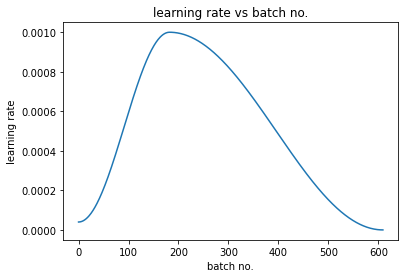

In [42]:
plot_lrs(history)

In [43]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
        means = torch.tensor(means).reshape(1, 3, 1, 1)
        stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label: tulip (4)
Prediction: tulip


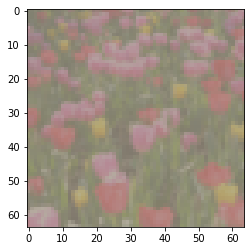

In [44]:
img, label = valid_ds[0]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Prediction:', pred)

Label: daisy (0)
Prediction: daisy


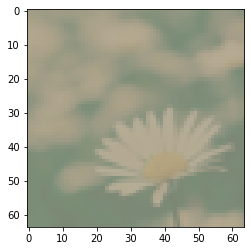

In [45]:
img, label = valid_ds[4]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Prediction:', pred)

Label: dandelion (1)
Prediction: dandelion


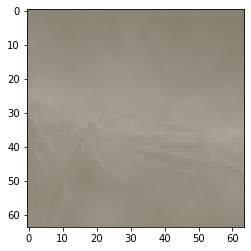

In [46]:
img, label = valid_ds[400]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Prediction:', pred)

Label: tulip (4)
Prediction: tulip


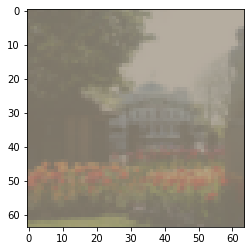

In [47]:
img, label = valid_ds[36]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Prediction:', pred)